In [11]:
import pandas as pd

PATH = "7282_1_dedupe.csv"
OUT  = "7282_1_dedupe_cleaned.csv"

df_raw = pd.read_csv(PATH)          # read
drop_cols = ['reviews.id','reviews.doRecommend','reviews.userCity','reviews.userProvince']

present = [c for c in drop_cols if c in df_raw.columns]
missing = [c for c in drop_cols if c not in df_raw.columns]
if missing: print("Not found, skipping:", missing)

df_clean = df_raw.drop(columns=present)   # make cleaned copy
df_clean.to_csv(OUT, index=False)


In [12]:
df = pd.read_csv("7282_1_dedupe_cleaned.csv")
summary = pd.DataFrame({
    'dtype': df.dtypes.astype(str),
    'n_unique': df.nunique(dropna=True)
}).sort_index()
summary

,dtype,n_unique
address,object,999
categories,object,396
city,object,761
country,object,1
latitude,float64,982
longitude,float64,983
name,object,879
postalCode,object,911
province,object,287
reviews.date,object,3009


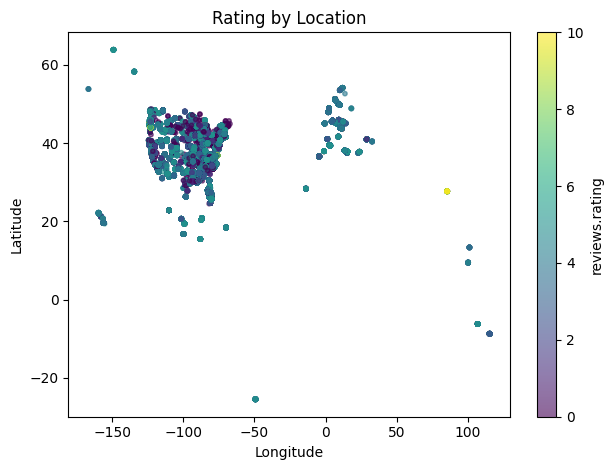

In [13]:
# MARK : --- NuMERIC vs NUMERIC PLOT ---

import pandas as pd
import matplotlib.pyplot as plt

# df already loaded from "7282_1_dedupe_cleaned.csv"
tmp = df[['longitude','latitude','reviews.rating']].copy()
tmp = tmp.apply(pd.to_numeric, errors='coerce').dropna()
tmp = tmp[tmp['longitude'].between(-180,180) & tmp['latitude'].between(-90,90)]

sc = plt.scatter(tmp['longitude'], tmp['latitude'],
                 c=tmp['reviews.rating'], s=10, alpha=0.6)
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Rating by Location')
plt.colorbar(sc, label='reviews.rating')
plt.tight_layout(); plt.show()


C:\Users\vanoh\AppData\Local\Temp\ipykernel_49148\3929685287.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


C:\Users\vanoh\AppData\Local\Temp\ipykernel_49148\3929685287.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


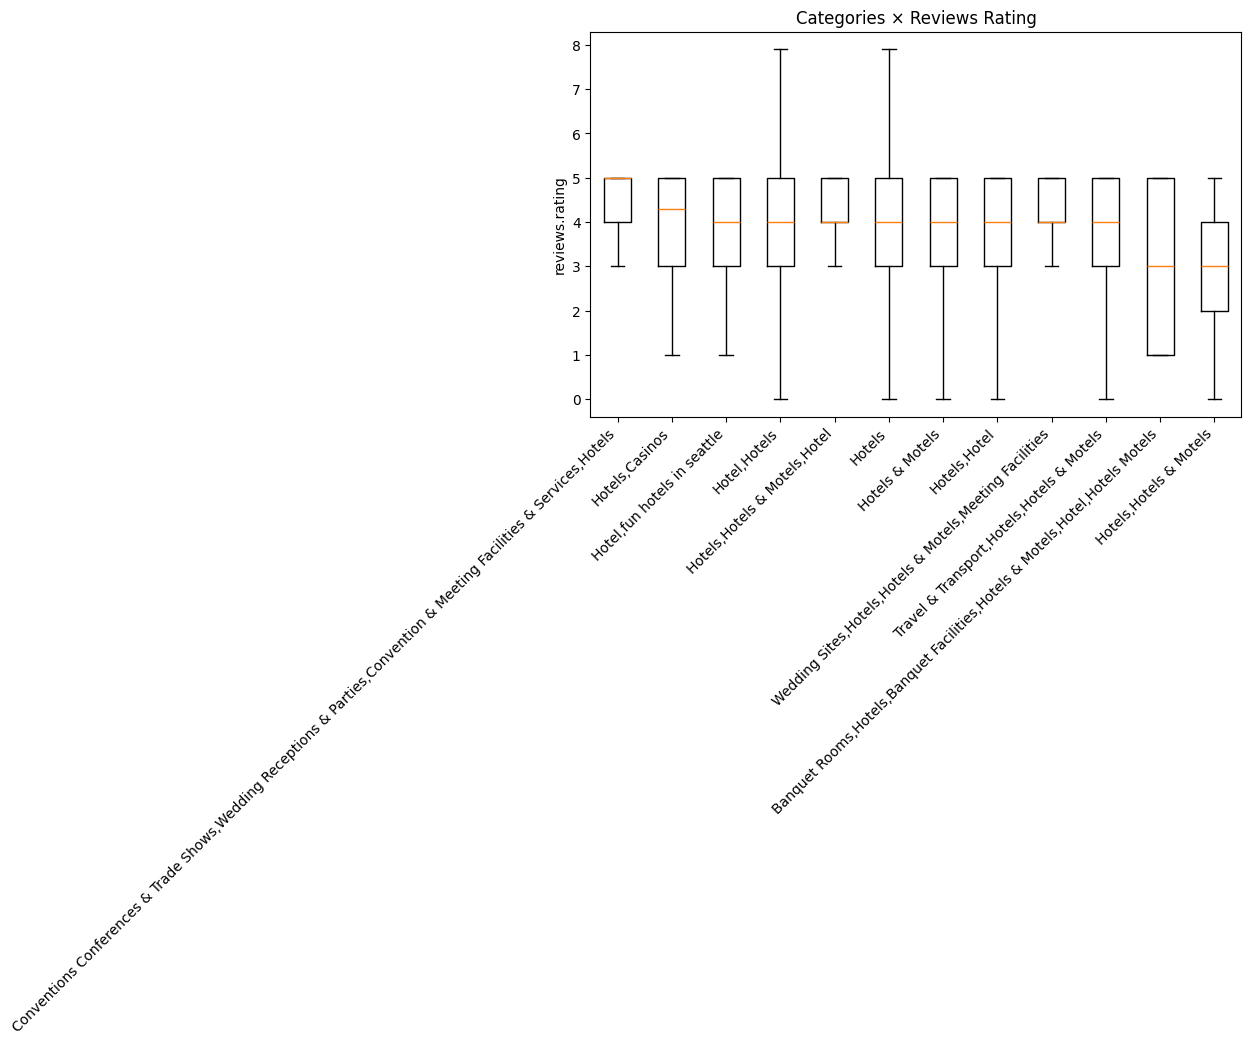

C:\Users\vanoh\AppData\Local\Temp\ipykernel_49148\3929685287.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


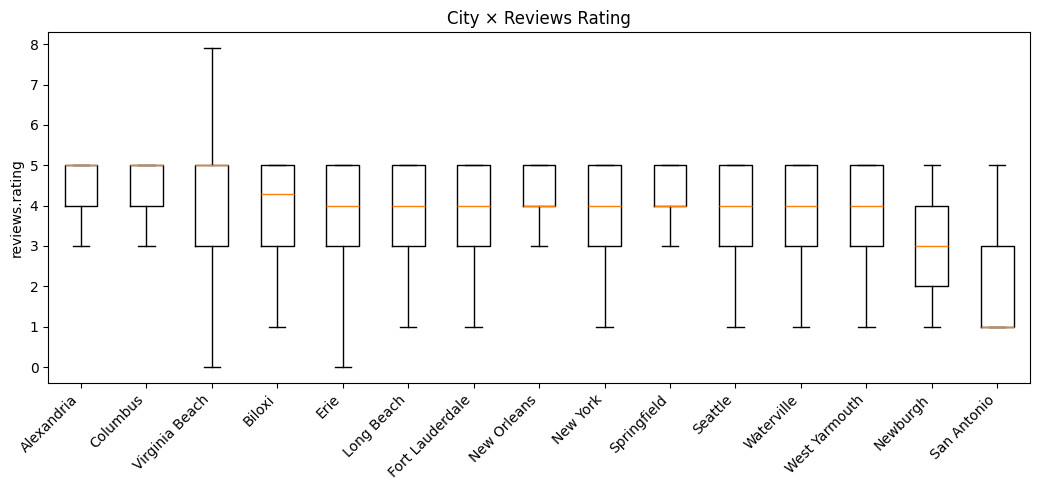

In [14]:
# MARK : --- CATEGORICAL vs NUMERIC PLOT ---

import pandas as pd
import matplotlib.pyplot as plt

def box_by_cat(df, cat_col, num_col, top_n=12, min_count=20, title=None):
    t = df[[cat_col, num_col]].copy()
    t[num_col] = pd.to_numeric(t[num_col], errors='coerce')
    t = t.dropna()


    freq = t[cat_col].value_counts()
    keep = freq[freq >= min_count].head(top_n).index
    t = t[t[cat_col].isin(keep)]

    order = t.groupby(cat_col)[num_col].median().sort_values(ascending=False).index

    data = [t.loc[t[cat_col] == c, num_col].values for c in order]
    plt.figure(figsize=(max(8, 0.7*len(order)), 5))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.ylabel(num_col)
    plt.title(title or f"{cat_col} × {num_col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

box_by_cat(df, 'categories', 'reviews.rating',
           top_n=12, min_count=20, title='Categories × Reviews Rating')

box_by_cat(df, 'city', 'reviews.rating',
           top_n=15, min_count=20, title='City × Reviews Rating')


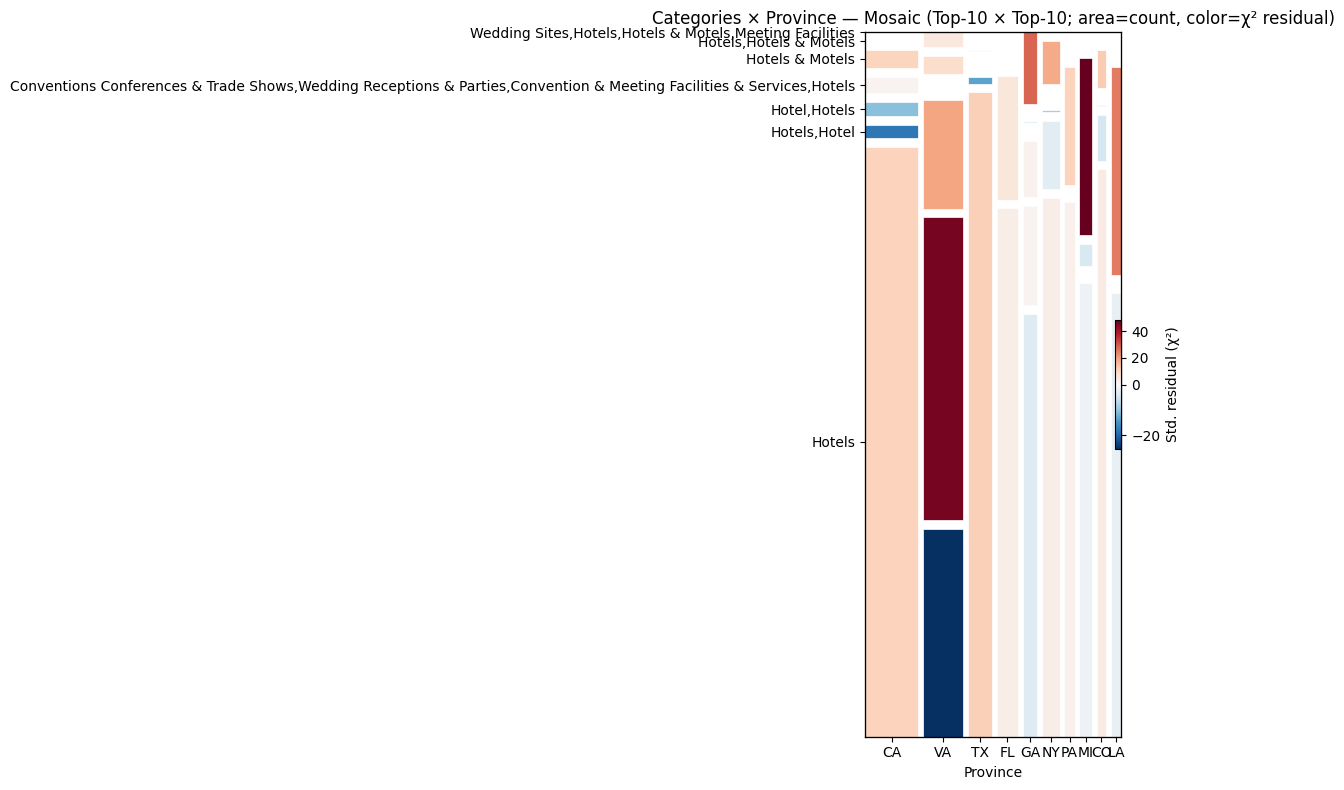

In [18]:
# --- MOSAIC: Categories × Province (Top-10 × Top-10) ---

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
from matplotlib import cm, colors

# 1) Clean + pick Top-10 on each axis
sub = df.copy()
sub['categories'] = sub['categories'].astype('string')
sub['province']   = sub['province'].astype('string')
sub = sub.dropna(subset=['categories','province'])

top_cats = sub['categories'].value_counts().head(10).index
top_prov = sub['province'].value_counts().head(10).index

sub = sub[sub['categories'].isin(top_cats) & sub['province'].isin(top_prov)]

# 2) Contingency (fixed order), drop empty rows/cols if any slipped through
ct = pd.crosstab(sub['province'], sub['categories'])
ct = ct.reindex(index=top_prov, columns=top_cats, fill_value=0)
ct = ct.loc[ct.sum(1) > 0, ct.sum(0) > 0]  # safety

# 3) χ² residuals with zero-expected guard
#    If any expected == 0, set residual to 0 for that cell (avoids inf/NaN)
chi2, p, dof, expected = chi2_contingency(ct.values, correction=False)
expected = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
with np.errstate(divide='ignore', invalid='ignore'):
    resid = (ct - expected) / np.sqrt(expected.where(expected > 0))
resid = resid.fillna(0.0).replace([np.inf, -np.inf], 0.0)

# 4) Colormap normalizer (fallback if TwoSlopeNorm not available)
try:
    norm = colors.TwoSlopeNorm(vmin=resid.values.min(), vcenter=0, vmax=resid.values.max())
except AttributeError:
    # Older matplotlib: approximate with symmetric range around 0
    m = np.nanmax(np.abs(resid.values))
    norm = colors.Normalize(vmin=-m, vmax=m)

# 5) Build data dict for mosaic
data_dict = {(r, c): int(v) for (r, c), v in ct.stack().items() if v > 0}

# 6) Safe properties lookup to avoid KeyError
def props(key):
    r, c = key
    val = resid.loc[r, c] if (r in resid.index and c in resid.columns) else 0.0
    return {"color": cm.RdBu_r(norm(val)), "ec": "white", "lw": 0.5}

# 7) Plot
fig_h = max(8, 0.4 * len(ct.index))
fig, ax = plt.subplots(figsize=(12, fig_h))
mosaic(data_dict, gap=0.02, properties=props, labelizer=lambda k: "", ax=ax)

ax.set_title("Categories × Province — Mosaic (Top-10 × Top-10; area=count, color=χ² residual)")
ax.set_xlabel("Province"); ax.set_ylabel("")

sm = cm.ScalarMappable(cmap=cm.RdBu_r, norm=norm); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label("Std. residual (χ²)")

plt.tight_layout(); plt.show()
